In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas
import random



In [66]:
def getDataset():
    #import dataset
    raw = fetch_california_housing(as_frame=True)
    
    #get input and output
    X = raw.data.values
    X = np.array(X,dtype='float32')
    np.apply_along_axis(standardize,axis=1,arr=X)
    Y = raw.target.values
    Y = np.array(Y,dtype='float32')
    n = len(X)
    r = 0.079
    x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=1-r)
    
    x_val = x_train[int(len(x_train)*r):]
    part_x_train = x_train[:int(len(x_train)*r)]
    y_val = y_train[int(len(y_train)*r):]
    part_y_train = y_train[:int(len(y_train)*r)]
    
    train_data = torch.utils.data.TensorDataset(torch.from_numpy(part_x_train),torch.from_numpy(part_y_train))
    valid_data = torch.utils.data.TensorDataset(torch.from_numpy(x_val),torch.from_numpy(y_val))
    test_data =  torch.utils.data.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test))

    print(len(part_x_train))

    return train_data,valid_data,test_data,y_test

In [67]:
getDataset()

128


(<torch.utils.data.dataset.TensorDataset at 0x7ff2a8e23910>,
 array([3.425  , 5.00001, 3.435  , ..., 1.304  , 2.811  , 3.553  ],
       dtype=float32))

In [3]:
def standardize(arr):
    arr[0] = (abs(arr[0]) - 3.870671003)/1.899821718
    arr[1] = (abs(arr[1]) - 28.63948643)/12.58555761
    arr[2] = (abs(arr[2]) - 5.428999742)/2.474173139
    arr[3] = (abs(arr[3]) - 1.09667515)/0.473910857
    arr[4] = (abs(arr[4]) - 1425.476744)/1132.462122
    arr[5] = (abs(arr[5]) - 3.070655159)/10.38604956
    arr[6] = (abs(arr[6]) - 35.63186143)/2.135952397
    arr[7] = (abs(arr[7]) - 119.5697045)/2.003531724

In [4]:
class RegularDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(RegularDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = torch.nn.Dropout(p=float(kwargs['dropout_rate']))
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
         

In [5]:
class SWDropOut(torch.nn.Module):
    def __init__(self,**kwargs):
        super().__init__()
        self.group_size = int(kwargs['group_size'])
        self.drop_per_group = int(kwargs['drop_per_group'])
        self.scalar = 1/((self.group_size-self.drop_per_group)/self.group_size)
        
    # def forward(self,x):
    #     if self.training:
    #         scalar_mask = torch.full(x.size(),self.scalar)
    #         size=torch.Size([int(len(x)/self.group_size),])
    #         indexes_to_mask = torch.randint(0,self.group_size,size)
    #         index=0
    #         for itm in indexes_to_mask:
    #             scalar_mask[index+itm]=0
    #             index+=self.group_size 
    # 
    #         x = torch.multiply(x,scalar_mask)
    #         # print(x.requires_grad)
    #         return x
    #     else:
    #         return x

    def forward(self, x):
        if self.training:
            scalar_mask = torch.full(x.size(),self.scalar)
            for i in range(0,len(x),self.group_size):
                masked_count=0
                while masked_count < self.drop_per_group:
                    index = random.randint(0, self.group_size-1) 
                    if scalar_mask[i+index] !=0:
                        scalar_mask[i+index]=0
                        masked_count+=1
            x = torch.multiply(x,scalar_mask)
            # print(x)
            return x
        else:
            return x


In [6]:
class SWDropOutModel(torch.nn.Module):
    def __init__(self,**kwargs):
        super(SWDropOutModel,self).__init__()
        
        self.linear1 = torch.nn.Linear(8,first_layer_size)
        self.activation1 = torch.nn.Sigmoid()
        self.dropout1 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
        self.activation2 = torch.nn.Sigmoid()
        self.dropout2 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
        self.activation3 = torch.nn.Sigmoid()
        self.dropout3 = SWDropOut(group_size=kwargs['group_size'],drop_per_group=kwargs['drop_per_group'])
        self.linear4 = torch.nn.Linear(third_layer_size,1)
        self.activation4 = torch.nn.ReLU()
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        x = self.linear4(x)
        x = self.activation4(x)
        return x
        
 

In [7]:
# class InverseBDO(torch.nn.Module):
#     def __init__(self,**kwargs):
#         super().__init__()
#         self.group_size = int(kwargs['group_size'])
#         # self.scalar = 1/((self.group_size-1)/self.group_size)
#         
#     def forward(self,x):
#         if self.training:
#             scalar_mask = torch.zeros(x.size())
#             size=torch.Size([int(len(x)/self.group_size),])
#             indexes_to_mask = torch.randint(0,self.group_size,size)
#             index=0
#             for itm in indexes_to_mask:
#                 scalar_mask[index+itm]=group_size
#                 index+=self.group_size 
# 
#             x = torch.multiply(x,scalar_mask)
#             # print(x.requires_grad)
#             return x
#         else:
#             return x

# class InverseGbdoModel(torch.nn.Module):
#     def __init__(self,**kwargs):
#         super(InverseGbdoModel,self).__init__()
#         
#         self.linear1 = torch.nn.Linear(8,first_layer_size)
#         self.activation1 = torch.nn.Sigmoid()
#         self.dropout1 = InverseBDO(group_size=kwargs['group_size'])
#         # self.linear2 = torch.nn.Linear(first_layer_size,second_layer_size)
#         # self.activation2 = torch.nn.Sigmoid()
#         # self.dropout2 = InverseBDO(group_size=kwargs['group_size'])
#         self.linear3 = torch.nn.Linear(second_layer_size,third_layer_size)
#         self.activation3 = torch.nn.Sigmoid()
#         self.dropout3 = InverseBDO(group_size=kwargs['group_size'])
#         self.linear4 = torch.nn.Linear(third_layer_size,1)
#         self.activation4 = torch.nn.ReLU()
#         
#     def forward(self,x):
#         x = self.linear1(x)
#         x = self.activation1(x)
#         x = self.dropout1(x)
#         # x = self.linear2(x)
#         # x = self.activation2(x)
#         # x = self.dropout2(x)
#         x = self.linear3(x)
#         x = self.activation3(x)
#         x = self.dropout3(x)
#         x = self.linear4(x)
#         x = self.activation4(x)
#         return x
#         

In [8]:
def train(dataset, mdl, optm, loss_func):
    mdl.train(True)
    running_loss=0
    count=0
    for x,y in dataset:
        optm.zero_grad()
        output = mdl(x)
    
        training_loss = loss_func(output, torch.unsqueeze(y,0))
        training_loss.backward()
        
        optm.step()
        
        running_loss += training_loss.item()
        count+=1
        
    return running_loss/count
        
def validate(dataset, mdl, loss_func):
    mdl.eval()
    running_val_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            validation_loss = loss_func(output, torch.unsqueeze(y,0))
            running_val_loss += validation_loss.item()
            count+=1
            
    return running_val_loss/count
        
def predict(dataset, mdl,loss_func):
    mdl.eval()
    predictions=[]
    test_loss=0
    count=0
    with torch.no_grad():
        for x,y in dataset:
            output = mdl(x)
            test_loss+=loss_func(output,torch.unsqueeze(y,0))
            predictions.append(float(output))
            count+=1
    return predictions,(test_loss/count)
        


In [9]:
def train_and_test_dropout(training,validation,testing,epochs,dropout_rate):
    DO_model = RegularDropOutModel(dropout_rate=dropout_rate)
    DO_optimizer = torch.optim.SGD(DO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        loss = train(training,DO_model,DO_optimizer,loss_fn)
        print(loss)
        valid_loss = validate(validation,DO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,DO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [10]:
def train_and_test_gb_dropout(training,validation,testing,epochs,group_size,drop_per_group):
    SWDO_model = SWDropOutModel(group_size=group_size,drop_per_group=drop_per_group)
    SWDO_optimizer = torch.optim.SGD(SWDO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        loss = train(training,SWDO_model,SWDO_optimizer,loss_fn)
        print(loss)
        valid_loss = validate(validation,SWDO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,SWDO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [11]:
def train_and_test_inverse_gbdo(training,validation,testing,epochs,group_size):
    Inverse_GBDO_model = InverseGbdoModel(group_size=group_size)
    Inverse_GBDO_optimizer = torch.optim.SGD(Inverse_GBDO_model.parameters(recurse=True),lr=0.01)
    loss_fn = torch.nn.MSELoss()
    train_loss =[]
    val_loss=[]
    for i in epochs:
        loss = train(training,Inverse_GBDO_model,Inverse_GBDO_optimizer,loss_fn)
        print(loss)
        valid_loss = validate(validation,Inverse_GBDO_model,loss_fn)
        train_loss.append(loss)
        val_loss.append(valid_loss)

    y_pred,test_loss = predict(testing,Inverse_GBDO_model,loss_fn)
    
    return train_loss,val_loss,test_loss,y_pred

In [12]:
def makeGraph(loss, val_loss,y_hat,y_true,epochs):
    fig, (ax11,ax12) = plt.subplots(2,1)
    fig.set_figwidth(6)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,loss,'bo',label='Training Loss')
    ax11.plot(epochs,val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    plt.show()

In [13]:
def makeGraphs_2(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,y_true,epochs):
    fig, ((ax11,ax21),(ax12,ax22)) = plt.subplots(2,2)
    fig.set_figwidth(12)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Inverse Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    plt.show()

In [14]:
def makeGraphs_3(do_loss, do_val_loss,do_y_hat,gbdo_loss, gbdo_val_loss,gbdo_y_hat,inverse_loss, inverse_val_loss,inverse_y_hat,y_true,epochs):
    fig, ((ax11,ax21,ax31),(ax12,ax22,ax32)) = plt.subplots(2,3)
    fig.set_figwidth(18)
    fig.set_figheight(12)
    
    ax11.set_title('Regular DropOut')
    ax11.plot(epochs,do_loss,'bo',label='Training Loss')
    ax11.plot(epochs,do_val_loss,'r',label='Validation Loss')
    ax11.set(xlabel='Epochs',ylabel='Loss')
    ax11.set_ylim(0.1,1.5)
    ax11.legend()
    
    x_temp=[-.25,5.5]
    y_temp=[-0.25,5.5]
    ax12.scatter(y_true,do_y_hat,s=2)
    ax12.plot(x_temp, y_temp, 'r')
    ax12.set(xlabel='Actual',ylabel='Predicted')
    ax12.set_ylim(-.25,5.5)
    ax12.set_xlim(-.25,5.5)
    
    ax21.set_title('Group Based DropOut')
    ax21.plot(epochs,gbdo_loss,'bo',label='Training Loss')
    ax21.plot(epochs,gbdo_val_loss,'r',label='Validation Loss')
    ax21.set(xlabel='Epochs',ylabel='Loss')
    ax21.set_ylim(0.1,1.5)
    ax21.legend()
   
    ax22.scatter(y_true,gbdo_y_hat,s=2)
    ax22.plot(x_temp, y_temp, 'r')
    ax22.set(xlabel='Actual',ylabel='Predicted')
    ax22.set_ylim(-.25,5.5)
    ax22.set_xlim(-.25,5.5)
    
    ax31.set_title('Inverse Group Based DropOut')
    ax31.plot(epochs,inverse_loss,'bo',label='Training Loss')
    ax31.plot(epochs,inverse_val_loss,'r',label='Validation Loss')
    ax31.set(xlabel='Epochs',ylabel='Loss')
    ax31.set_ylim(0.1,1.5)
    ax31.legend()
   
    ax32.scatter(y_true,inverse_y_hat,s=2)
    ax32.plot(x_temp, y_temp, 'r')
    ax32.set(xlabel='Actual',ylabel='Predicted')
    ax32.set_ylim(-.25,5.5)
    ax32.set_xlim(-.25,5.5)
    
    
    
    plt.show()

In [73]:
global first_layer_size
global second_layer_size
global third_layer_size
training_data, valid_data, test_data, y_true = getDataset()

epochs = range(500)
dropout_rate = 0.0
group_size=5
drop_per_group=4
first_layer_size = 64
second_layer_size = 64
third_layer_size = 32

t_loss_dropout, v_loss_dropout, tst_loss_dropout, y_pred_dropout = train_and_test_dropout(training_data,valid_data,test_data,epochs,dropout_rate)
# t_loss_gbdo,    v_loss_gbdo,    tst_loss_gbdo,    y_pred_gbdo    = train_and_test_gb_dropout(training_data,valid_data,test_data,epochs,group_size,drop_per_group)
# t_loss_inverse,    v_loss_inverse,    tst_loss_inverse,    y_pred_inverse    = train_and_test_inverse_gbdo(training_data,valid_data,test_data,epochs,group_size)

# print("GBDO Test Loss = ",tst_loss_gbdo)
# print("I_GBDO Test Loss = ", tst_loss_inverse)
print("  DO Test Loss = ",tst_loss_dropout)

# makeGraph(t_loss_gbdo,v_loss_gbdo,y_pred_gbdo,y_true,epochs)
# makeGraphs_2(t_loss_dropout,v_loss_dropout,y_pred_dropout,t_loss_gbdo,v_loss_gbdo,y_pred_gbdo,y_true,epochs)
# makeGraphs_2(t_loss_dropout,v_loss_dropout,y_pred_dropout,t_loss_inverse,v_loss_inverse,y_pred_inverse,y_true,epochs)
# makeGraphs_3(t_loss_dropout,v_loss_dropout,y_pred_dropout,t_loss_gbdo,v_loss_gbdo,y_pred_gbdo,t_loss_inverse,v_loss_inverse,y_pred_inverse,y_true,epochs)


128
1.4061902463065152
1.3244562527179937
1.314862006383919
1.3059288951663808
1.2975832765405357
1.2897526328865894
1.2823663993822834
1.275356701672763
1.2686588360934365
1.2622111700293317
1.2559544444466155
1.2498315103330242
1.243786259069111
1.2377627538101024
1.231703825831346
1.2255497581998434
1.2192365805972258
1.2126939168866784
1.2058432391643237
1.1985946757999955
1.1908440745492044
1.1824691612406752
1.173324788519821
1.163237594637291
1.1519995395714244
1.1393607602428304
1.1250221059803494
1.1086289189046852
1.0897688114052926
1.067979368811848
1.042775171750236
1.0137116072778554
0.9805046397389106
0.943228573642493
0.9025786519316625
0.8601173776876934
0.8183057357076677
0.7800806456457394
0.747957229079816
0.7231051953042869
0.7050688616437242
0.692313209125814
0.683080518510863
0.6759628206246688
0.6700467504358656
0.6648138928252081
0.6599916478057537
0.6554399289652295
0.6510843354830347
0.6468823126811221
0.6428060819086951
0.6388355621352986
0.6349550565929007
0

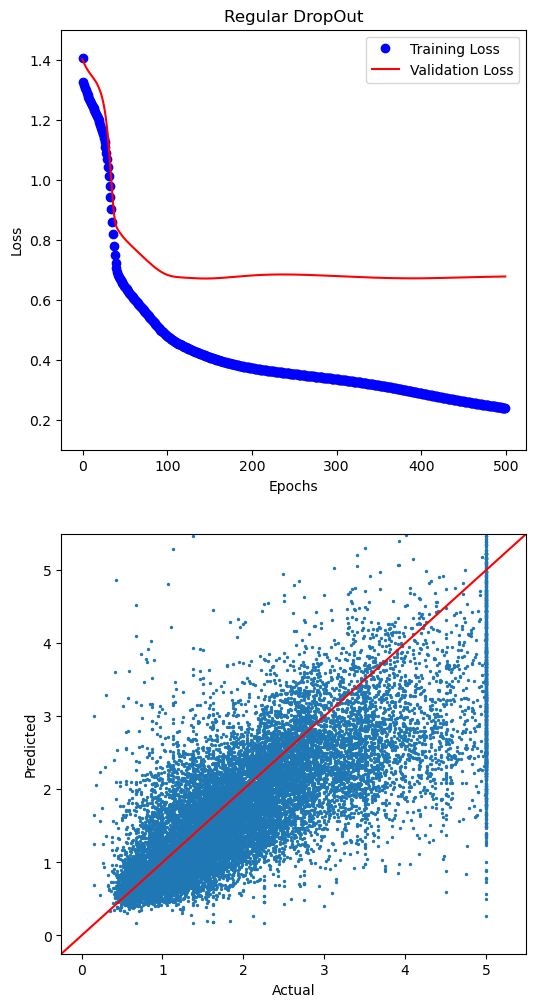

NameError: name 'tst_loss_gbdo' is not defined

In [74]:
makeGraph(t_loss_dropout,v_loss_dropout,y_pred_dropout,y_true,epochs)
print("GBDO Test Loss = ",tst_loss_gbdo)